# Portfolio Optimization Based on Forecast

Setup and Imports

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pypfopt import EfficientFrontier, plotting

# USER CONFIG
PROCESSED_FILE = "processed_data.csv"
FORECAST_CSV = "forecast_df.csv"
MIN_TSLA_WEIGHT = 0.10
MAX_WEIGHT = 0.6
RISK_FREE = 0.0
HIST_WINDOW_DAYS = None  # None => full history
OUTDIR = "task4_outputs"
os.makedirs(OUTDIR, exist_ok=True)

# Load processed data
df = pd.read_csv(PROCESSED_FILE, parse_dates=["Date"], index_col="Date")
prices = pd.DataFrame({
    "TSLA": df["Close_TSLA"],
    "BND":  df["Close_BND"],
    "SPY":  df["Close_SPY"]
}).dropna()

print("Using price range:", prices.index.min().date(), "to", prices.index.max().date())

Using price range: 2015-08-13 to 2025-07-30


Compute historical daily returns

In [5]:
rets = prices.pct_change().dropna()
if HIST_WINDOW_DAYS is not None:
    rets = rets.iloc[-HIST_WINDOW_DAYS:]

Load TSLA forecast -> compute expected return for TSLA

In [6]:
if "forecast_df" in globals():
    tsla_forecast = forecast_df["Forecast"]
else:
    if os.path.exists(FORECAST_CSV):
        ff = pd.read_csv(FORECAST_CSV, parse_dates=True, index_col=0)
        # try common column names
        if "Forecast" in ff.columns:
            tsla_forecast = ff["Forecast"]
        elif "LSTM_median" in ff.columns:
            tsla_forecast = ff["LSTM_median"]
        elif "LSTM_point" in ff.columns:
            tsla_forecast = ff["LSTM_point"]
        else:
            tsla_forecast = ff.select_dtypes(include=[np.number]).iloc[:,0]
    else:
        raise FileNotFoundError("No forecast_df in memory and forecast_df.csv not found. Provide Task 3 output.")

Compute expected annual return for TSLA from forecast

In [7]:
tsla_forecast_daily = tsla_forecast.pct_change().dropna()
mu_tsla_annual = float(tsla_forecast_daily.mean() * 252)   # scalar
print(f"TSLA expected annual return from forecast: {mu_tsla_annual:.4%}")

TSLA expected annual return from forecast: 11.0635%


Historical expected returns for BND & SPY

In [8]:
mu_bnd = float(rets["BND"].mean() * 252)
mu_spy = float(rets["SPY"].mean() * 252)
print(f"BND historical annual return: {mu_bnd:.4%}")
print(f"SPY historical annual return: {mu_spy:.4%}")

BND historical annual return: 1.8505%
SPY historical annual return: 14.4969%


Compose expected returns vector and covariance matrix (annualized)

In [9]:
tickers = ["TSLA","BND","SPY"]
mu_vector = pd.Series([mu_tsla_annual, mu_bnd, mu_spy], index=tickers)
S = rets.cov() * 252
S = S.loc[tickers, tickers]   # ensure order
print("\nExpected returns (annual):")
print(mu_vector)
print("\nAnnualized covariance matrix:")
print(S)


Expected returns (annual):
TSLA    0.110635
BND     0.018505
SPY     0.144969
dtype: float64

Annualized covariance matrix:
          TSLA       BND       SPY
TSLA  0.388191  0.002277  0.057474
BND   0.002277  0.002721  0.000907
SPY   0.057474  0.000907  0.031125


Setup EfficientFrontier and constraints

In [10]:
# EfficientFrontier can accept pd.Series and pd.DataFrame with tickers index
ef = EfficientFrontier(mu_vector, S)

# Enforce long-only (no shorts)
ef.add_constraint(lambda w: w >= 0)

# Enforce minimum TSLA weight if requested
if MIN_TSLA_WEIGHT is not None and MIN_TSLA_WEIGHT > 0:
    # Ensure min weight is feasible: it must be <= 1
    if MIN_TSLA_WEIGHT >= 1.0:
        raise ValueError("MIN_TSLA_WEIGHT must be less than 1.0 (e.g., 0.1 for 10%)")
    ef.add_constraint(lambda w: w[0] >= float(MIN_TSLA_WEIGHT))

# Enforce per-asset max weight if specified
if MAX_WEIGHT is not None:
    if not (0 < MAX_WEIGHT <= 1):
        raise ValueError("MAX_WEIGHT must be in (0,1]")
    ef.add_constraint(lambda w: w <= float(MAX_WEIGHT))

Optimize: Max Sharpe (tangency)

In [11]:
try:
    ef_max = ef  # already configured with constraints
    raw_weights = ef_max.max_sharpe(risk_free_rate=RISK_FREE)
    weights_max = ef_max.clean_weights()
    perf_max = ef_max.portfolio_performance(risk_free_rate=RISK_FREE, verbose=False)
except Exception as e:
    raise RuntimeError(f"Max Sharpe optimization failed: {e}")

Optimize: Min Volatility (with same constraints)

In [12]:
ef_min = EfficientFrontier(mu_vector, S)
ef_min.add_constraint(lambda w: w >= 0)
if MIN_TSLA_WEIGHT and MIN_TSLA_WEIGHT > 0:
    ef_min.add_constraint(lambda w: w[0] >= float(MIN_TSLA_WEIGHT))
if MAX_WEIGHT is not None:
    ef_min.add_constraint(lambda w: w <= float(MAX_WEIGHT))

try:
    raw_weights_min = ef_min.min_volatility()
    weights_min = ef_min.clean_weights()
    perf_min = ef_min.portfolio_performance(risk_free_rate=RISK_FREE, verbose=False)
except Exception as e:
    raise RuntimeError(f"Min Vol optimization failed: {e}")

Efficient Frontier (with constraints) - Plot

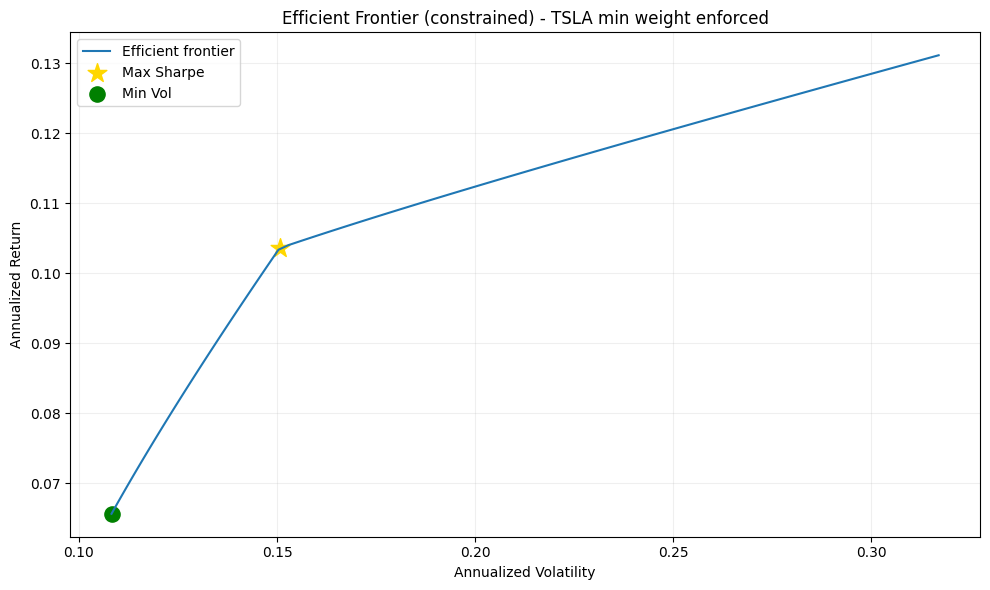

In [13]:
# Build an ef_plot object with same constraints for plotting
ef_plot = EfficientFrontier(mu_vector, S)
ef_plot.add_constraint(lambda w: w >= 0)
if MIN_TSLA_WEIGHT and MIN_TSLA_WEIGHT > 0:
    ef_plot.add_constraint(lambda w: w[0] >= float(MIN_TSLA_WEIGHT))
if MAX_WEIGHT is not None:
    ef_plot.add_constraint(lambda w: w <= float(MAX_WEIGHT))

fig, ax = plt.subplots(figsize=(10,6))
plotting.plot_efficient_frontier(ef_plot, ax=ax, show_assets=False)
# Mark portfolios
ax.scatter(perf_max[1], perf_max[0], marker='*', color='gold', s=200, label='Max Sharpe')
ax.scatter(perf_min[1], perf_min[0], marker='o', color='green', s=120, label='Min Vol')
ax.set_xlabel("Annualized Volatility")
ax.set_ylabel("Annualized Return")
ax.set_title("Efficient Frontier (constrained) - TSLA min weight enforced")
ax.legend()
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

Print & save results

In [14]:
def print_port(name, weights, perf):
    ann_ret, ann_vol, ann_sharpe = perf
    print(f"\n{name}:")
    for k, v in weights.items():
        print(f"  {k}: {v:.2%}")
    print(f"  Expected annual return: {ann_ret:.2%}")
    print(f"  Annual volatility: {ann_vol:.2%}")
    print(f"  Sharpe ratio (rf={RISK_FREE}): {ann_sharpe:.2f}")

print_port("Maximum Sharpe Portfolio (constrained)", weights_max, perf_max)
print_port("Minimum Volatility Portfolio (constrained)", weights_min, perf_min)


Maximum Sharpe Portfolio (constrained):
  TSLA: 10.00%
  BND: 30.00%
  SPY: 60.00%
  Expected annual return: 10.36%
  Annual volatility: 15.06%
  Sharpe ratio (rf=0.0): 0.69

Minimum Volatility Portfolio (constrained):
  TSLA: 10.00%
  BND: 60.00%
  SPY: 30.00%
  Expected annual return: 6.57%
  Annual volatility: 10.82%
  Sharpe ratio (rf=0.0): 0.61


In [15]:
# Save CSVs
pd.Series(weights_max).rename("weight").to_csv(os.path.join(OUTDIR, "max_sharpe_weights_constrained.csv"))
pd.Series(weights_min).rename("weight").to_csv(os.path.join(OUTDIR, "min_vol_weights_constrained.csv"))
print(f"\nSaved weights to {OUTDIR}")


Saved weights to task4_outputs
